# Tutorials on `Dandiset-000167` (Daste odor set 2021-11)

## 1. Requirements and dataset download

Please follow all the steps written in the [README.md](./README.md) to setup everything needed to run this notebook.

In [1]:
import time
import numpy as np
import pandas as pd
import warnings
from pathlib import Path

from pynwb import NWBHDF5IO
from nwbwidgets import nwb2widget

import utils

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('mpl.sty')

All the data are at: <https://dandiarchive.org/dandiset/000167/>

You can download all the files with the following

In [3]:
![ -d data ] || mkdir data
!dandi download --existing skip \
    --output-dir data \
    "https://dandiarchive.org/dandiset/000167"

PATH                                          SIZE      DONE    DONE% CHECKSUM STATUS    MESSAGE         
dandiset.yaml                                                                  skipped   already exists  
sub-164/sub-164_ses-20200124T161514_ophys.nwb                                  skipped   already exists  
sub-163/sub-163_ses-20200212T160655_ophys.nwb                                  skipped   already exists  
sub-8/sub-8_ses-20200204T180138_ophys.nwb                                      skipped   already exists  
sub-9/sub-9_ses-20200204T154200_ophys.nwb                                      skipped   already exists  
sub-7/sub-7_ses-20200213T113524_ophys.nwb                                      skipped   already exists  
Summary:                                      0 Bytes   0 Bytes                6 skipped 6 already exists
                                              +975.8 MB 0.00%                                            
2022-09-28 09:20:41,491 [    INFO] Logs saved 

In [4]:
!ls data/**/*

data/000167/dandiset.yaml

data/000167/sub-163:
sub-163_ses-20200212T160655_ophys.nwb

data/000167/sub-164:
sub-164_ses-20200124T161514_ophys.nwb

data/000167/sub-7:
sub-7_ses-20200213T113524_ophys.nwb

data/000167/sub-8:
sub-8_ses-20200204T180138_ophys.nwb

data/000167/sub-9:
sub-9_ses-20200204T154200_ophys.nwb


In [5]:
!cat data/**/*.yaml

# DO NOT EDIT THIS FILE LOCALLY. ALL LOCAL UPDATES WILL BE LOST.
# It can be edited online at https://dandiarchive.org/dandiset/000167
# and obtained from the dandiarchive.
'@context': https://raw.githubusercontent.com/dandi/schema/master/releases/0.6.0/context.json
about: []
access:
- schemaKey: AccessRequirements
  status: dandi:OpenAccess
assetsSummary:
  approach:
  - name: microscopy approach; cell population imaging
    schemaKey: ApproachType
  dataStandard:
  - identifier: RRID:SCR_015242
    name: Neurodata Without Borders (NWB)
    schemaKey: StandardsType
  measurementTechnique:
  - name: analytical technique
    schemaKey: MeasurementTechniqueType
  numberOfBytes: 975789016
  numberOfFiles: 5
  numberOfSubjects: 5
  schemaKey: AssetsSummary
  species:
  - identifier: http://purl.obolibrary.org/obo/NCBITaxon_10090
    name: House mouse
    schemaKey: SpeciesType
  variableMeasured:
  - PlaneSegmentation
  - ProcessingModule
citation: PIERRÉ, Andrea (2022) Odor_Set_1 (Version

## 2. Overview of example data

For the purpose of illustration, we are going to load data from only 1 mouse, and only visualize/analyze such data 

### 2.1. Load data 

We suppress some warnings here when loading the data in.

It's not important but if you remove it, you will see warnings similar to these. This is because of the `suite2p.io.nwb` used at the time referenced each plane's the ROI section to the same global `RoiResponseSeries` (see [here](https://gitlab.com/fleischmann-lab/calcium-imaging/calimag/-/issues/75)).

```text
.../lib/python3.10/site-packages/pynwb/ophys.py:364: UserWarning: RoiResponseSeries 'Plane_1': 
    The second dimension of data does not match the length of rois. Your data may be transposed.
.../lib/python3.10/site-packages/pynwb/base.py:193: UserWarning: RoiResponseSeries 'Plane_1': 
    Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
```

In [6]:
data_path = Path("data").joinpath("000167", "sub-164", "sub-164_ses-20200124T161514_ophys.nwb")
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    nwb = NWBHDF5IO(data_path, "r").read()

In [7]:
nwb2widget(nwb)

### 2.2. Some overview

We will focus on extracting `stimulus['odor']` and computing calcium activity `dF/F_0` via `processing['ophys']`.

Though we will not be analyzing `acquisition['flow']`, we will include code to compute the sniff rates from that. 

Additionally, using the `timestamps` in each variable and `trials` module, we will be splitting the data into trials (8 trials x 10 odors)

In [8]:
print(f'Num trials = {len(nwb.trials)}')
print(f"Odor ids = {np.unique(nwb.stimulus['odor'].data[:])}")

Num trials = 80
Odor ids = [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


Below we are going to inspect some of the `ophys` submodule

In [9]:
print('>>> Suite2p ophys')
print(nwb.processing['ophys'])

F_series = nwb.processing['ophys']['Fluorescence'].roi_response_series
print(f'>>> Fluorescence x {len(F_series)} planes')

print(nwb.processing['ophys']['Fluorescence'])
for p, f in F_series.items():
    print(f'>>> Fluorescence {p} data')
    print(f.data, end='\n\n')
    
print('>>> iscell data')
is_cell = nwb.processing['ophys']['ImageSegmentation']['PlaneSegmentation']['iscell'].data
print(f'{is_cell} ({sum(is_cell[:,0]):.0f} is legit cells)', end='\n\n')

>>> Suite2p ophys
ophys pynwb.base.ProcessingModule at 0x140585357057600
Fields:
  data_interfaces: {
    Backgrounds_0 <class 'pynwb.base.Images'>,
    Deconvolved <class 'pynwb.ophys.Fluorescence'>,
    Fluorescence <class 'pynwb.ophys.Fluorescence'>,
    ImageSegmentation <class 'pynwb.ophys.ImageSegmentation'>,
    Neuropil <class 'pynwb.ophys.Fluorescence'>
  }
  description: optical physiology processed data

>>> Fluorescence x 3 planes
Fluorescence pynwb.ophys.Fluorescence at 0x140585357059760
Fields:
  roi_response_series: {
    Plane_1 <class 'pynwb.ophys.RoiResponseSeries'>,
    Plane_2 <class 'pynwb.ophys.RoiResponseSeries'>,
    Plane_3 <class 'pynwb.ophys.RoiResponseSeries'>
  }

>>> Fluorescence Plane_1 data
<HDF5 dataset "data": shape (96, 10880), type "<f4">

>>> Fluorescence Plane_2 data
<HDF5 dataset "data": shape (232, 10880), type "<f4">

>>> Fluorescence Plane_3 data
<HDF5 dataset "data": shape (203, 10880), type "<f4">

>>> iscell data
<HDF5 dataset "iscell": shap

## 3. Data extraction and pre-processing

### 3.1. Get individual data sources out

In [10]:
odor = utils.extract_odor(nwb) # odor identity
sniff = utils.compute_sniff(nwb) # compute sniff rate

Odor identity extraction started ... done (0.55 seconds)
Sniff rate computation started ... done (1.56 seconds)


In [11]:
dFF0_kwargs = dict(
    k_neu=0.7, # F = F - 0.7 x F_neu    
    combine_planes=True, # combine all planes
    use_iscell=True, # from suite2p to filter cells
    norm_F=True, # normalize to dF/F0 from (F = F - k_neu x F_neu)
    norm_kwargs=dict(
        tau_m = 0.5, # median filter window in seconds
        tau_q = -1, # quantile window (sec) to calculate baseline, -1 is everything per trial
        q=0.08, # quantile to use as baseline
        div=True, # dF/F0 or just dF
        bidir=False, # whether to do the reverse pass as well        
    )
)

dFF0 = utils.compute_dFFO(nwb, **dFF0_kwargs)

dF/F0 computation started ...


Plane_3: 100%|████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 52.53it/s]

	[dF/F0 computation] ... done (4.21 seconds)


### 3.2. Aggregate them and align timings

In [12]:
# this aggregates and aligns the timing of fluorescence and other sniff data
data = utils.aggregate_data_by_trial(odor, sniff, dFF0)

Aggregate data by trial started ... done (0.01 seconds)


In [13]:
d0 = data[0]
print(f"The sampling rate is {1/(np.diff(d0['t']))[0]:.2f} Hz")
print(f'The structure and shape of each trial dictionary (x {len(data)}):')
{k: [v.shape, type(v)] for k, v in d0.items()}

The sampling rate is 4.51 Hz
The structure and shape of each trial dictionary (x 80):


{'t': [(136,), numpy.ndarray],
 'odor': [(), numpy.int64],
 'sniff': [(136,), numpy.ndarray],
 'dFF0': [(284, 136), numpy.ndarray]}

### 3.3. Plot activity of an ROI

Each panel is the activity of the selected ROI of a given odor ID. Thin gray traces are individual trials. Thick blue traces are the mean activity, and the shading is the `1.96 x SEM`.

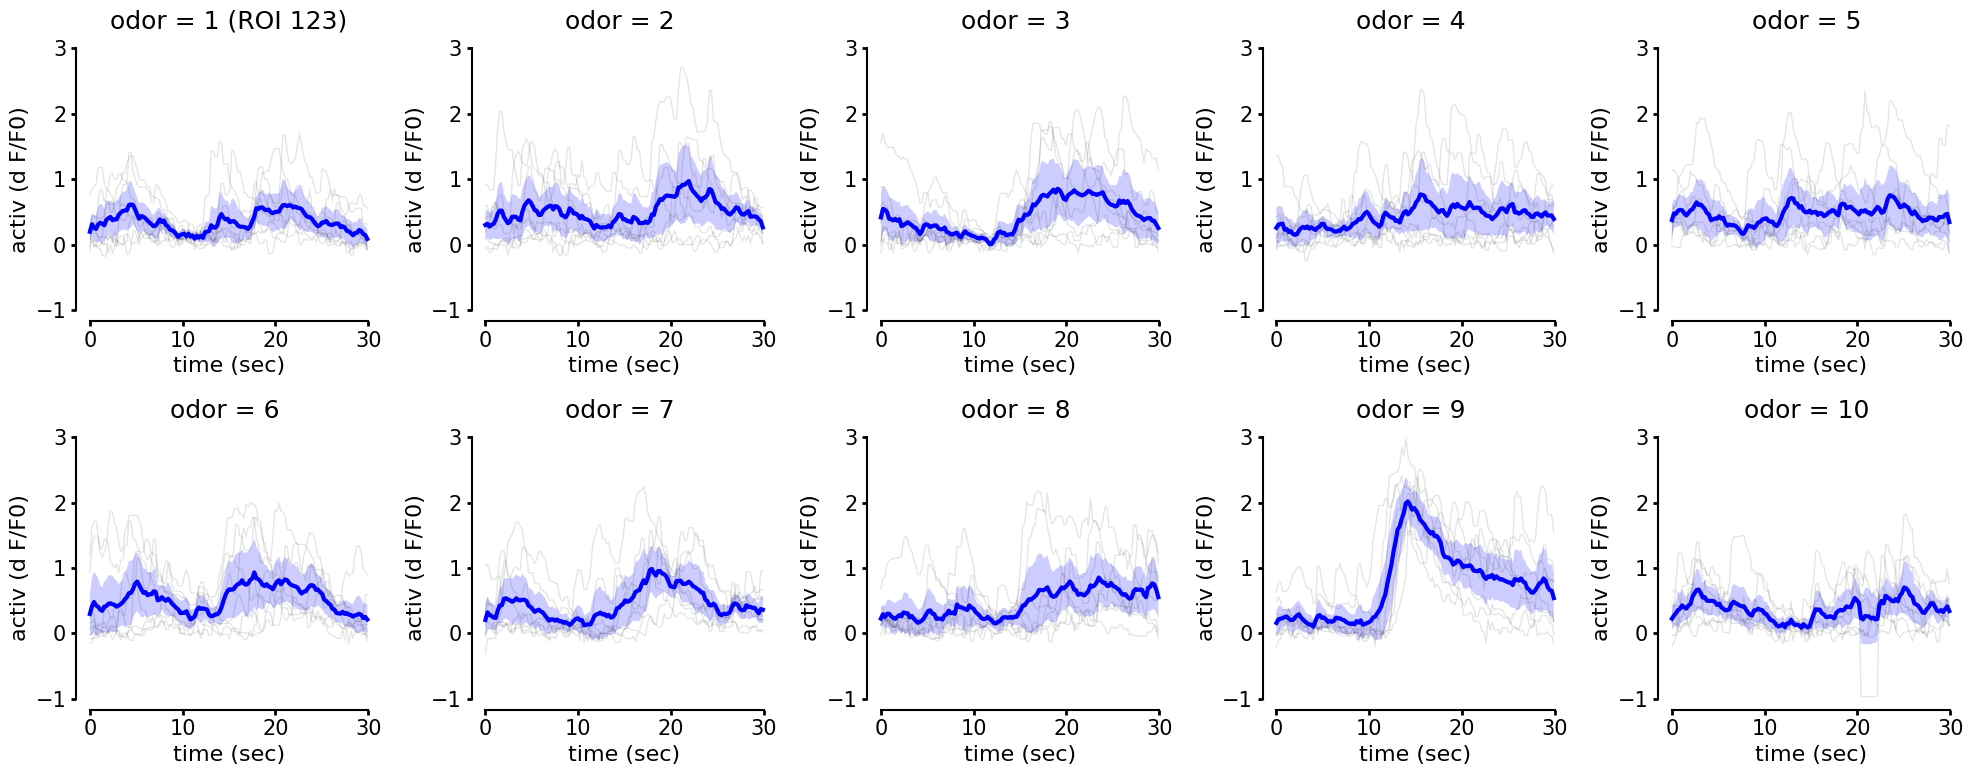

In [14]:
utils.plot_activity_of_roi(
    roi=123,
    data=data,
    figsize=(20,8)
)

## 4. Analyze response to stimulus

### 4.1. Obtain the maximum of selected time windows

In [15]:
agg_data = utils.time_aggregate_by_trial(
    data, 
    win_sec = dict( # define time windows (seconds) of aggregation
        baseline = [5, 10], # before stim
        stimulus = [11, 16], # main response to stim
        longresp = [10, 20], # can have overlapping windows, e.g. here to observe longer response window 
        poststim = [25, 30] # some post stim window
    ),
    dFF0_fn = np.max
)

In [16]:
# let's examine the output dimensions a bit
print(agg_data[2]['t']) # time windows (same as argument above)
print({k: v.shape for k,v in agg_data[2]['dFF0'].items()}) # print out shapes, i.e. array of `num_rois` elements 

{'baseline': array([ 5, 10]), 'stimulus': array([11, 16]), 'longresp': array([10, 20]), 'poststim': array([25, 30])}
{'baseline': (284,), 'stimulus': (284,), 'longresp': (284,), 'poststim': (284,)}


Let's save the `stimulus` response window for later analysis 

In [17]:
win_period = 'stimulus'
agg_activ = np.concatenate([X['dFF0'][win_period].reshape(1,-1) for X in agg_data], axis=0) 
agg_activ.shape # trials x rois

(80, 284)

In [18]:
unq_odors = np.unique(odor)
num_odors = len(unq_odors)
num_trials = len(odor)
print(f'{num_trials} trials with {num_odors} unique odors')

80 trials with 10 unique odors


### 4.2. Correlations of trials

From the previous section, we obtain the `agg_activ` matrix of the `stimulus`-response window (between 11-16 second). 

Let's see how the activity vectors correlate with each other. Are trials within the same odor usually more correlated than between different odors? 

In [19]:
trial_corr = np.corrcoef(agg_activ) # trials x trials
trial_corr[range(num_trials),range(num_trials)] = np.nan # to ignore identity entries when aggregating

# take the average based on odor
agg_trial_corr = pd.DataFrame(trial_corr)\
                    .assign(odor=odor)\
                    .groupby('odor')\
                    .agg(np.nanmean)\
                    .transpose()\
                    .assign(odor=odor)\
                    .groupby('odor')\
                    .agg(np.nanmean)\
                    .to_numpy()

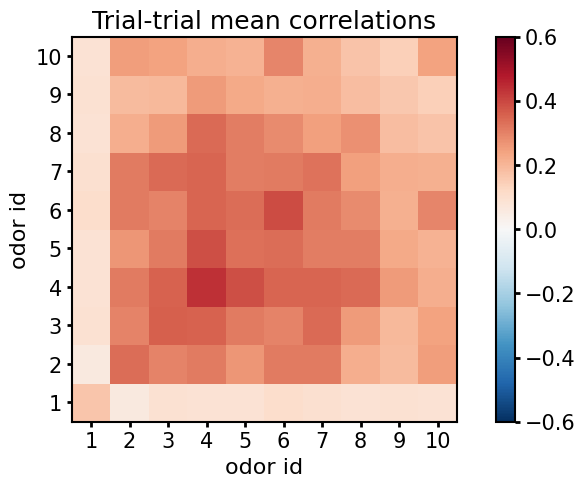

In [20]:
# plot the matrix
plt.figure(figsize=(10,5))
plt.imshow(agg_trial_corr,
           vmin = -0.6, 
           vmax = 0.6,
           origin='lower', 
           cmap = 'RdBu_r') # to account for potential negative corr

plt.xticks(range(num_odors), unq_odors)
plt.yticks(range(num_odors), unq_odors)
plt.xlabel('odor id')
plt.ylabel('odor id')
plt.title('Trial-trial mean correlations')
plt.colorbar()
plt.show()

Here's a table of the intra-odor correlation, sorted descending.

Note `odor = 1` is a control, and have higher in-class correlation than out-class correlations.

Plus, also notice that the 3 top odors with high intra correlation are `[3,4,6]`

In [21]:
pd.DataFrame(dict(
    odor = unq_odors,
    corr = np.diag(agg_trial_corr)
)).sort_values(by='corr', ascending=False)

odor      corr
3     4  0.438783
5     6  0.390212
2     3  0.357125
1     2  0.333236
4     5  0.329027
6     7  0.326244
7     8  0.273697
9    10  0.240583
0     1  0.168206
8     9  0.159403

### 4.3. Odor classification based on stimulus response

Let's now try to classify odor indentities based on the stimulus population responses. 

And previously, we analyzed with activity in the `stimulus` window. But we could also utilize the `baseline` window and get the difference of activity, i.e. `F[stimulus] - F[baseline]`, as features for our classifier.

For illustration purposes, we're going to use an SVM classifier with repeated stratified k-fold training/testing on single-CPU and report the performance from that.  

In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.base import clone as skclone
from tqdm import tqdm 

#### 4.3.1. Create and train classifier

In [23]:
def get_d_act(X):
    V = X['dFF0']
    V = V['stimulus'] - V['baseline']
    return V.reshape(1,-1)

d_activ = np.concatenate([get_d_act(X) for X in agg_data], axis=0) 

In [24]:
def classifier_performance(X, y, base_model, n_splits=5, n_repeats=100, desc='classifier'):
    confusions = [] 
    accuracies = [] 
    
    rskf = RepeatedStratifiedKFold(
        n_splits = n_splits,
        n_repeats = n_repeats
    )
    
    tqdm_kwargs = dict(
        total = n_splits*n_repeats, 
        desc = desc
    )
    
    for train, test in tqdm(rskf.split(X, y), **tqdm_kwargs ):
        # get data
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]
        
        # predict
        model = skclone(base_model) # ensure independence between iterations
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # analyze
        accuracies.append(np.mean(y_pred == y_test))
        confusions.append(confusion_matrix(y_test, y_pred, normalize='true')[:,:,None])
    
    accuracies = np.array(accuracies) * 100
    confusions = np.concatenate(confusions, axis=2) * 100
    
    return dict(
        mean_accuracy = np.mean(accuracies),
        mean_confusion = np.mean(confusions, axis=2),
        accuracies = accuracies, 
        confusions = confusions
    )


In [25]:
models = { # could also use make_pipeline here for scaling; could also add more models here
    'Support vector classifier' : SVC(C=1, class_weight='balanced', gamma='scale', kernel='linear'),
}

In [26]:
np.random.seed(1937329)

# here we used single CPU for demo purposes, took a few seconds
n_splits = 4
n_repeats = 200

results = dict()
for name, model in models.items():
    results[name] = classifier_performance(
        X = d_activ.copy(), # or agg_activ.copy(),
        y = odor.copy(),
        base_model = model, 
        n_splits = n_splits, 
        n_repeats = n_repeats,
        desc = name
    )
    print(f"\t Mean accuracy of {name} is {results[name]['mean_accuracy']:.2f} %")
    

Support vector classifier: 100%|███████████████████████████████████| 800/800 [00:01<00:00, 413.71it/s]

	 Mean accuracy of Support vector classifier is 54.22 %


#### 4.3.2. Visualize classification performance

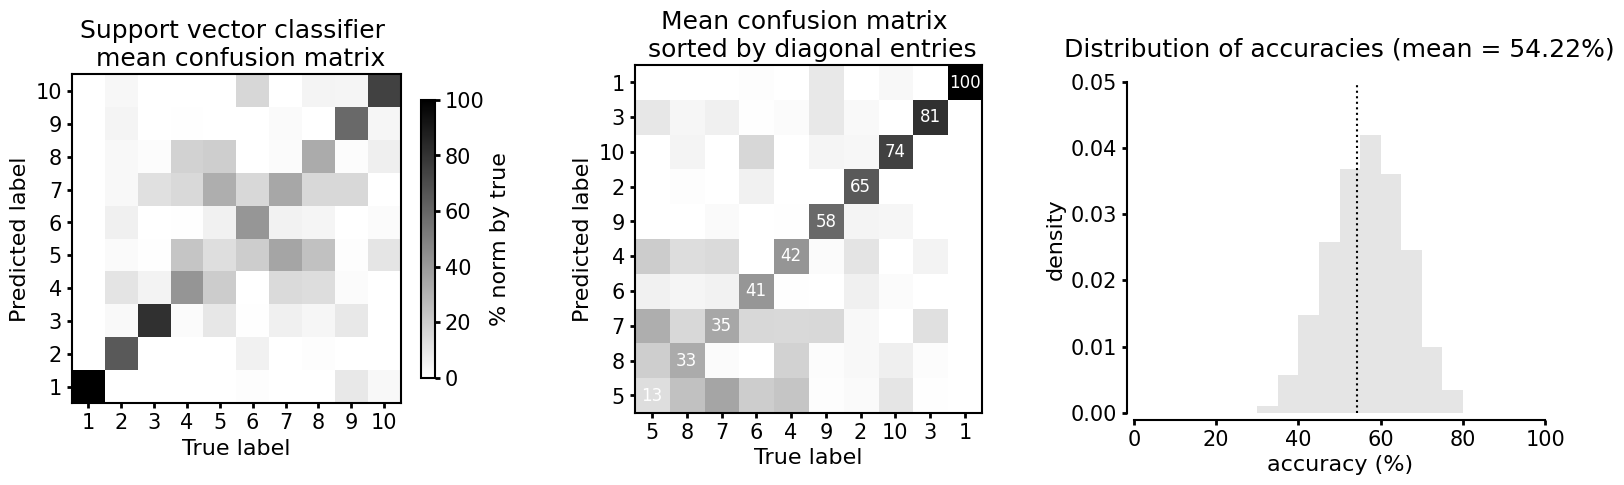

In [27]:
num_models = len(results)

plt.figure(figsize=(16,5))

for i, (name, result) in enumerate(results.items()): 
    
    # plot mean confusion matrix 
    plt.subplot(num_models, 3, 3*i+1)
    mean_acc = result['mean_accuracy']
    confmat = result['mean_confusion'].T
    plt.imshow(confmat, 
               cmap = 'gray_r', origin='lower',
               vmin = 0, vmax = 100)
    
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title(f'{name} \n mean confusion matrix')
    
    plt.xticks(range(num_odors), unq_odors)
    plt.yticks(range(num_odors), unq_odors)
    
    cbar = plt.colorbar(shrink = 0.8)
    cbar.set_label('% norm by true')
    
    # replot matrix but sorted by diagonal line + add text
    plt.subplot(num_models, 3, 3*i+2)
    
    sorted_conf_ind = np.diag(confmat).argsort()
    sorted_conf_mat = confmat[sorted_conf_ind,:][:,sorted_conf_ind]
    
    plt.imshow(sorted_conf_mat,
               cmap = 'gray_r', origin='lower',
               vmin = 0, vmax = 100)
    
    [plt.text(x,x,'%.f' %(sorted_conf_mat[x,x]), 
              fontsize=12, ha='center', va='center', c='w') 
     for x in range(num_odors)]
    
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title('Mean confusion matrix \n sorted by diagonal entries')
    
    plt.xticks(range(num_odors), unq_odors[sorted_conf_ind])
    plt.yticks(range(num_odors), unq_odors[sorted_conf_ind])
    
    # histogram of accuracies
    plt.subplot(num_models, 3, 3*i+3)
    plt.hist(result['accuracies'], color='k', alpha=0.1, density=True)
    plt.vlines(result['mean_accuracy'], ymin=0, ymax=0.05, colors='k', linestyles=':')
    plt.xlim([0,100])
    
    plt.xlabel('accuracy (%)')
    plt.ylabel('density')
    plt.title(f'Distribution of accuracies (mean = {mean_acc:.2f}%)')
    
    sns.despine(trim=True,ax=plt.gca(), offset=5)
    
plt.tight_layout()
plt.show()

This toy example with SVM shows that a handful of odors are classifiable and discriminable from population activity in the piriform cortex.

Congrats! You have reached the end of the tutorial. But it is definitely not the end of what can be done with the data set. There is also the sniff data not yet used, and similar data with 4 other subjects. 

Feel free to explore different types of analyses, build complicated classifiers and create sophisticated models from this dataset. We are excited to hear what you learn, and welcome any feedback on the tutorial or the dataset! 

Have fun! 